In [47]:
import tensorflow as tf
# from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from operator import itemgetter
import os
import glob
from tqdm.auto import tqdm, trange
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import h5py
from PIL import Image

SEED = 84
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.run_functions_eagerly(True)

In [2]:
# !wget https://www.cs.ubc.ca/labs/imager/tr/2017/DeepVideoDeblurring/DeepVideoDeblurring_Dataset.zip

In [3]:
# !unzip DeepVideoDeblurring_Dataset.zip

In [4]:
def load_img(img_path, shape = (360,640)):
  img = image.load_img(img_path, target_size=shape)
  x = image.img_to_array(img)
  # x = np.expand_dims(x, axis=0)
  # x = preprocess_input(x)

  return x

In [5]:
dataset_path = '/content/DeepVideoDeblurring_Dataset/quantitative_datasets'
dirs = os.listdir(dataset_path)

train_imgs = list()
test_imgs = list()

for dir in tqdm(dirs):
  train_imgs = train_imgs+glob.glob(os.path.join(dataset_path, dir, 'input', '*.jpg'))
  test_imgs = test_imgs+glob.glob(os.path.join(dataset_path, dir, 'GT', '*.jpg'))
  train_imgs = sorted(train_imgs)
  test_imgs = sorted(test_imgs)

  0%|          | 0/72 [00:00<?, ?it/s]

# No skip connections only resblocks

In [8]:
def deblur_model(input_shape=(720,1280)):
  X_input = tf.keras.layers.Input(shape = (None, None, 5))

  #Resblock with 3D Convs
  FX_1 = tf.keras.layers.Conv3D(16, (5,5,5), padding='same')(X_input)
  X_1 = tf.keras.layers.BatchNormalization()(FX_1)
  X_1 = tf.keras.layers.Conv3D(16, (5,5,5), padding='same')(X_1)
  X_1 = tf.keras.layers.Add()([FX_1, X_1])
  X_1 = tf.keras.layers.LeakyReLU(alpha=0.01)(X_1)

  #Resblock with 3D Convs
  FX_2 = tf.keras.layers.Conv3D(16, (5,5,5), padding='same')(X_1)
  X_2 = tf.keras.layers.BatchNormalization()(FX_2)
  X_2 = tf.keras.layers.Conv3D(16, (5,5,5), padding='same')(X_2)
  X_2 = tf.keras.layers.Add()([FX_2, X_2])
  X_2 = tf.keras.layers.LeakyReLU(alpha=0.01)(X_2)

  #Resblock with 3D Convs
  FX_3 = tf.keras.layers.Conv3D(16, (3,3,3), padding='same')(X_2)
  X_3 = tf.keras.layers.BatchNormalization()(FX_3)
  X_3 = tf.keras.layers.Conv3D(16, (3,3,3), padding='same')(X_3)
  X_3 = tf.keras.layers.Add()([FX_3, X_3])

  #Resblock with 3D Convs
  FX_4 = tf.keras.layers.Conv3D(1, (3,3,3), padding='same')(X_3)
  X_4 = tf.keras.layers.BatchNormalization()(FX_4)
  X_4 = tf.keras.layers.Conv3D(1, (3,3,3), padding='same')(X_4)
  X_4 = tf.keras.layers.Add()([FX_4, X_4])
  X_4 = tf.keras.layers.LeakyReLU(alpha=0.01)(X_4)

  #2D Convs with skip connections
  squeezed = tf.keras.layers.Reshape(X_4.shape[1:-1])(X_4)
  X_5 = tf.keras.layers.BatchNormalization()(squeezed)
  FX_5 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(X_5)
  X_5 = tf.keras.layers.BatchNormalization()(FX_5)
  FX_6 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(X_5)
  X_6 = tf.keras.layers.BatchNormalization()(X_5)
  X_6 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(FX_6)
  X_6 = tf.keras.layers.BatchNormalization()(X_6)
  X_6 = tf.keras.layers.Add()([FX_6, X_6])
  X_6 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(X_6)
  X_6 = tf.keras.layers.Add()([FX_5, X_6])
  X_6 = tf.keras.layers.BatchNormalization()(X_6)

  out = tf.keras.layers.Conv2D(3, (3,3), activation='relu', padding='same')(X_6) 
  # decoder_model = create_decoder(input=features_stacked.shape[1:])
  # reconstructed = decoder_model(features_stacked)
  model = Model(inputs = X_input, outputs = out)
  model.compile(optimizer='rmsprop', loss = 'mse')

  return model

In [9]:
deblur_model_test = deblur_model(input_shape=(360,640,3))

ValueError: ignored

In [ ]:
deblur_model_test.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 360, 640, 3  0           []                               
                                , 5)]                                                             
                                                                                                  
 conv3d (Conv3D)                (None, 360, 640, 3,  10016       ['input_1[0][0]']                
                                 16)                                                              
                                                                                                  
 batch_normalization (BatchNorm  (None, 360, 640, 3,  64         ['conv3d[0][0]']                 
 alization)                      16)                                                          

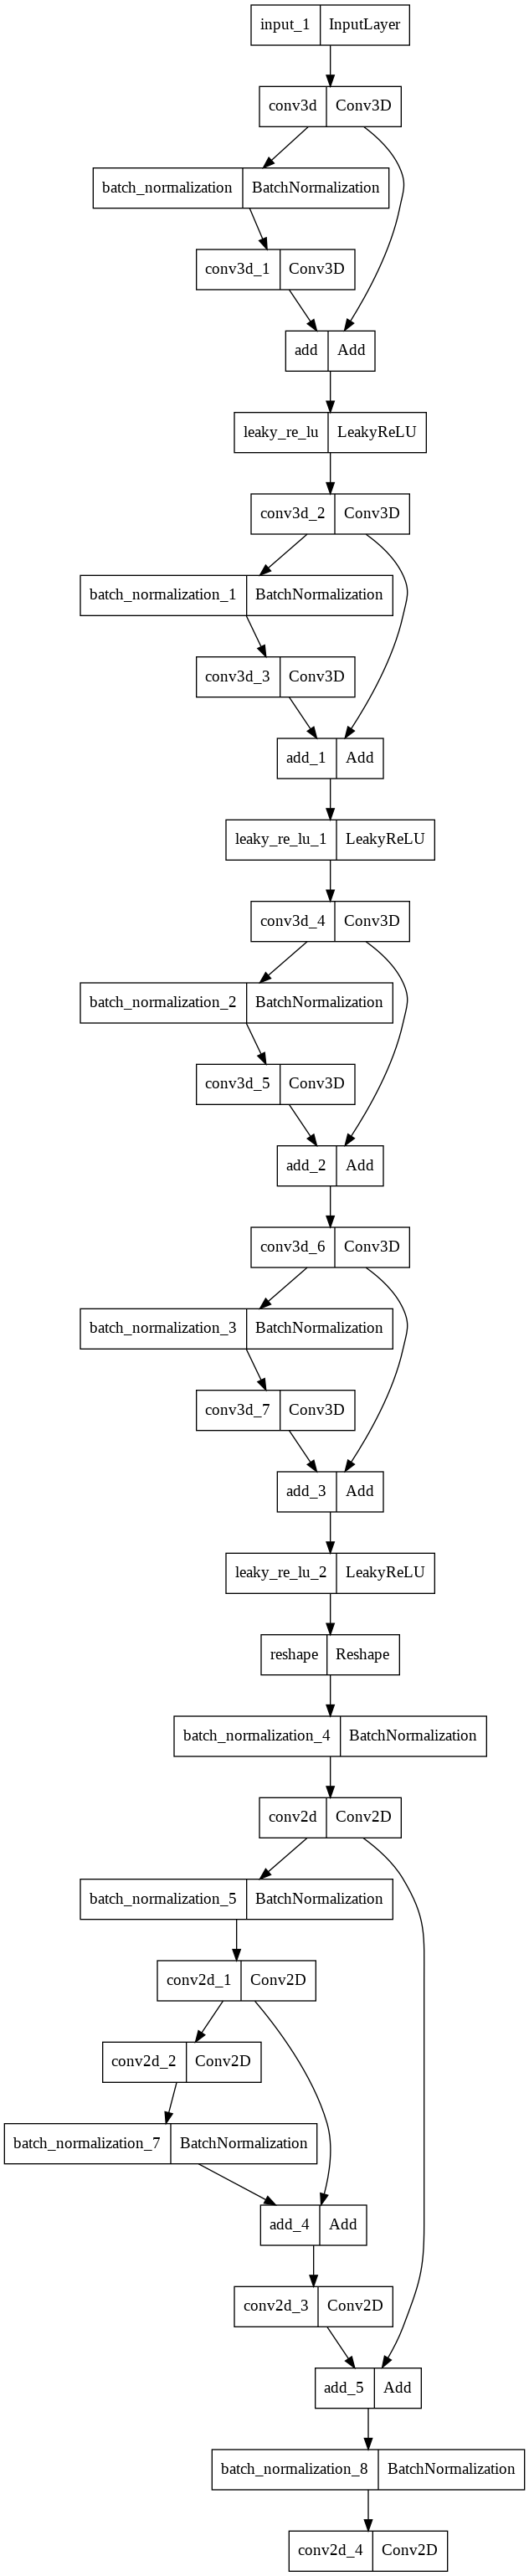

In [ ]:
tf.keras.utils.plot_model(deblur_model_test)

In [ ]:
num_epochs = 20
batch_size = 8

# my_callbacks = [
#     # tf.keras.callbacks.EarlyStopping(patience=2),
#     # tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
#     # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience = 5)
# ]

loss_list = list()

for i in range(num_epochs):
  rand_idx = np.random.choice(range(2, len(train_imgs)-2), batch_size)
  train_batch = np.array([[load_img(train_imgs[ind-2]), load_img(train_imgs[ind-1]), load_img(train_imgs[ind]), load_img(train_imgs[ind+1]), load_img(train_imgs[ind+2])] for ind in rand_idx])
  train_batch = train_batch.reshape((batch_size, 360, 640, 3, -1))
  test_batch = np.array([load_img(test_imgs[i]) for i in rand_idx])
  train_batch = np.squeeze(train_batch)/255.0
  test_batch = np.squeeze(test_batch)/255.0
  # np.max(train_batch)
  # # len(batch)
  # batch = np.squeeze(np.array(batch), axis = 2)
  # x_train = batch[:, 0:3]
  # x_test = batch[:, 3]
  # print(train_batch.shape)
  # print(test_batch.shape)  
  # batch = np.array(batch)
  # x_train.shape
  # x_test.shape
  print(f'Episodic Epoch {i+1}: ')
  hist = deblur_model_test.fit(train_batch, test_batch, epochs=10, verbose = 1)
  loss_list.append(hist.history['loss'])  

Episodic Epoch 1: 
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 25s 25s/step - loss: 1.0125
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 0.3744
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.4357
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.4035
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.3321
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.2326
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.1914
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 0.1751
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 0.1652
Epoch 10/10
1/1 [==============================] - 4s 4s/step - loss: 0.1760
Episodic Epoch 2: 
Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.1570
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.1455
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.1399
E

KeyboardInterrupt: ignored

In [ ]:
tf.keras.models.save_model(deblur_model_test, '/content/drive/MyDrive/DL_Dataset/model_1', save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL_Dataset/model_1/assets


# Skip connections and res-blocks

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def temporal_sharpness_model():
  X_input = tf.keras.layers.Input(shape = (360, 640, 3))

  prev_frame = tf.keras.layers.Lambda(lambda x: x[:,:,:,0])(X_input)
  T_frame = tf.keras.layers.Lambda(lambda x: x[:,:,:,1])(X_input)
  next_frame = tf.keras.layers.Lambda(lambda x: x[:,:,:,2])(X_input)

  prev_residue = tf.keras.layers.Subtract()([T_frame, prev_frame])
  # prev_residue = tf.keras.layers.Multiply()([prev_residue, prev_residue])
  prev_residue = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(prev_residue)
  next_residue = tf.keras.layers.Subtract()([next_frame, T_frame])
  # next_residue = tf.keras.layers.Multiply()([next_residue, next_residue])
  next_residue = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(next_residue)


  # #3D Convs with skip connections
  # FX_1 = tf.keras.layers.Conv3D(16, (7,7,3), padding='same')(X_input)
  # # FX_1 = tf.keras.layers.BatchNormalization()(FX_1)
  # FX_2 = tf.keras.layers.Conv3D(32, (3,3,3), padding='same')(FX_1)
  # FX_2 = tf.keras.layers.LeakyReLU(alpha=0.01)(FX_2)
  # X_2 = tf.keras.layers.Conv3D(32, (3,3,3), padding='same')(FX_2)
  # # X_2 = tf.keras.layers.BatchNormalization()(FX_2)
  # X_2 = tf.keras.layers.Add()([FX_2, X_2])
  # X_2 = tf.keras.layers.Conv3D(16, (3,3,3), padding='same')(X_2)
  # X_2 = tf.keras.layers.LeakyReLU(alpha=0.01)(X_2)
  # X_2 = tf.keras.layers.Add()([FX_1, X_2])
  # X_2 = tf.keras.layers.BatchNormalization()(X_2)

  # #Resblock with 3D Convs
  # FX_3 = tf.keras.layers.Conv3D(1, (3,3,3), padding='same')(X_2)
  # X_3 = tf.keras.layers.Conv3D(1, (3,3,3), padding='same')(FX_3)
  # X_3 = tf.keras.layers.Add()([FX_3, X_3])
  # X_3 = tf.keras.layers.LeakyReLU(alpha=0.01)(X_3)
  # X_3 = tf.keras.layers.BatchNormalization()(X_3)

  # #2D Convs with skip connections
  # squeezed = tf.keras.layers.Reshape(X_3.shape[1:-1])(X_3)
  # # X_5 = tf.keras.layers.BatchNormalization()(squeezed)
  T_frame = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(T_frame)
  X_5 = tf.keras.layers.Concatenate()([T_frame, prev_residue, next_residue])
  # print(X_5.shape)
  # X_5 = tf.keras.layers.Reshape((*X_5.shape[1:-1], 3, 2))(X_5)
  FX_5 = tf.keras.layers.Conv2D(16, (3,3), activation='linear', padding='same', use_bias=True)(X_5)
  FX_5 = tf.keras.layers.LeakyReLU(alpha=0.1)(FX_5)
  # X_5 = tf.keras.layers.BatchNormalization()(FX_5)
  FX_6 = tf.keras.layers.Conv2D(32, (3,3), activation='linear', padding='same', use_bias=True)(FX_5)
  FX_6 = tf.keras.layers.LeakyReLU(alpha=0.1)(FX_6)
  # X_6 = tf.keras.layers.BatchNormalization()(FX_6)
  X_6 = tf.keras.layers.Conv2D(32, (3,3), activation='linear', padding='same', use_bias=True)(FX_6)
  X_6 = tf.keras.layers.LeakyReLU(alpha=0.1)(X_6)
  # X_6 = tf.keras.layers.BatchNormalization()(X_6)
  X_6 = tf.keras.layers.Add()([FX_6, X_6])
  X_6 = tf.keras.layers.Conv2D(16, (3,3), activation='linear', padding='same', use_bias=True)(X_6)
  X_6 = tf.keras.layers.LeakyReLU(alpha=0.1)(X_6)
  X_6 = tf.keras.layers.Add()([FX_5, X_6])
  # X_6 = tf.keras.layers.BatchNormalization()(X_6)

  X_6 = tf.keras.layers.Conv2D(1, (3,3), activation='linear', padding='same', use_bias=True)(X_6)
  X_6 = tf.keras.layers.LeakyReLU(alpha=0.1)(X_6) 
  X_6 = tf.keras.layers.Add()([T_frame, X_6])
  X_6 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', use_bias=True)(X_6)
  X_6 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', use_bias=True)(X_6)
  # X_6 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', use_bias=True)(X_6)
  # X_6 = tf.keras.layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', use_bias=True)(X_6)
  X_6 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', use_bias=True)(X_6)
  X_6 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', use_bias=True)(X_6)
  out = tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same', use_bias=True)(X_6)
  # out = tf.keras.layers.Activation(activation='relu')(X_6)
  model = Model(inputs = X_input, outputs = out)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss = 'mse', metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

In [7]:
deblur_model_test = temporal_sharpness_model()
deblur_model_test.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 360, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 360, 640)     0           ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 360, 640)     0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 360, 640)     0           ['input_1[0][0]']            

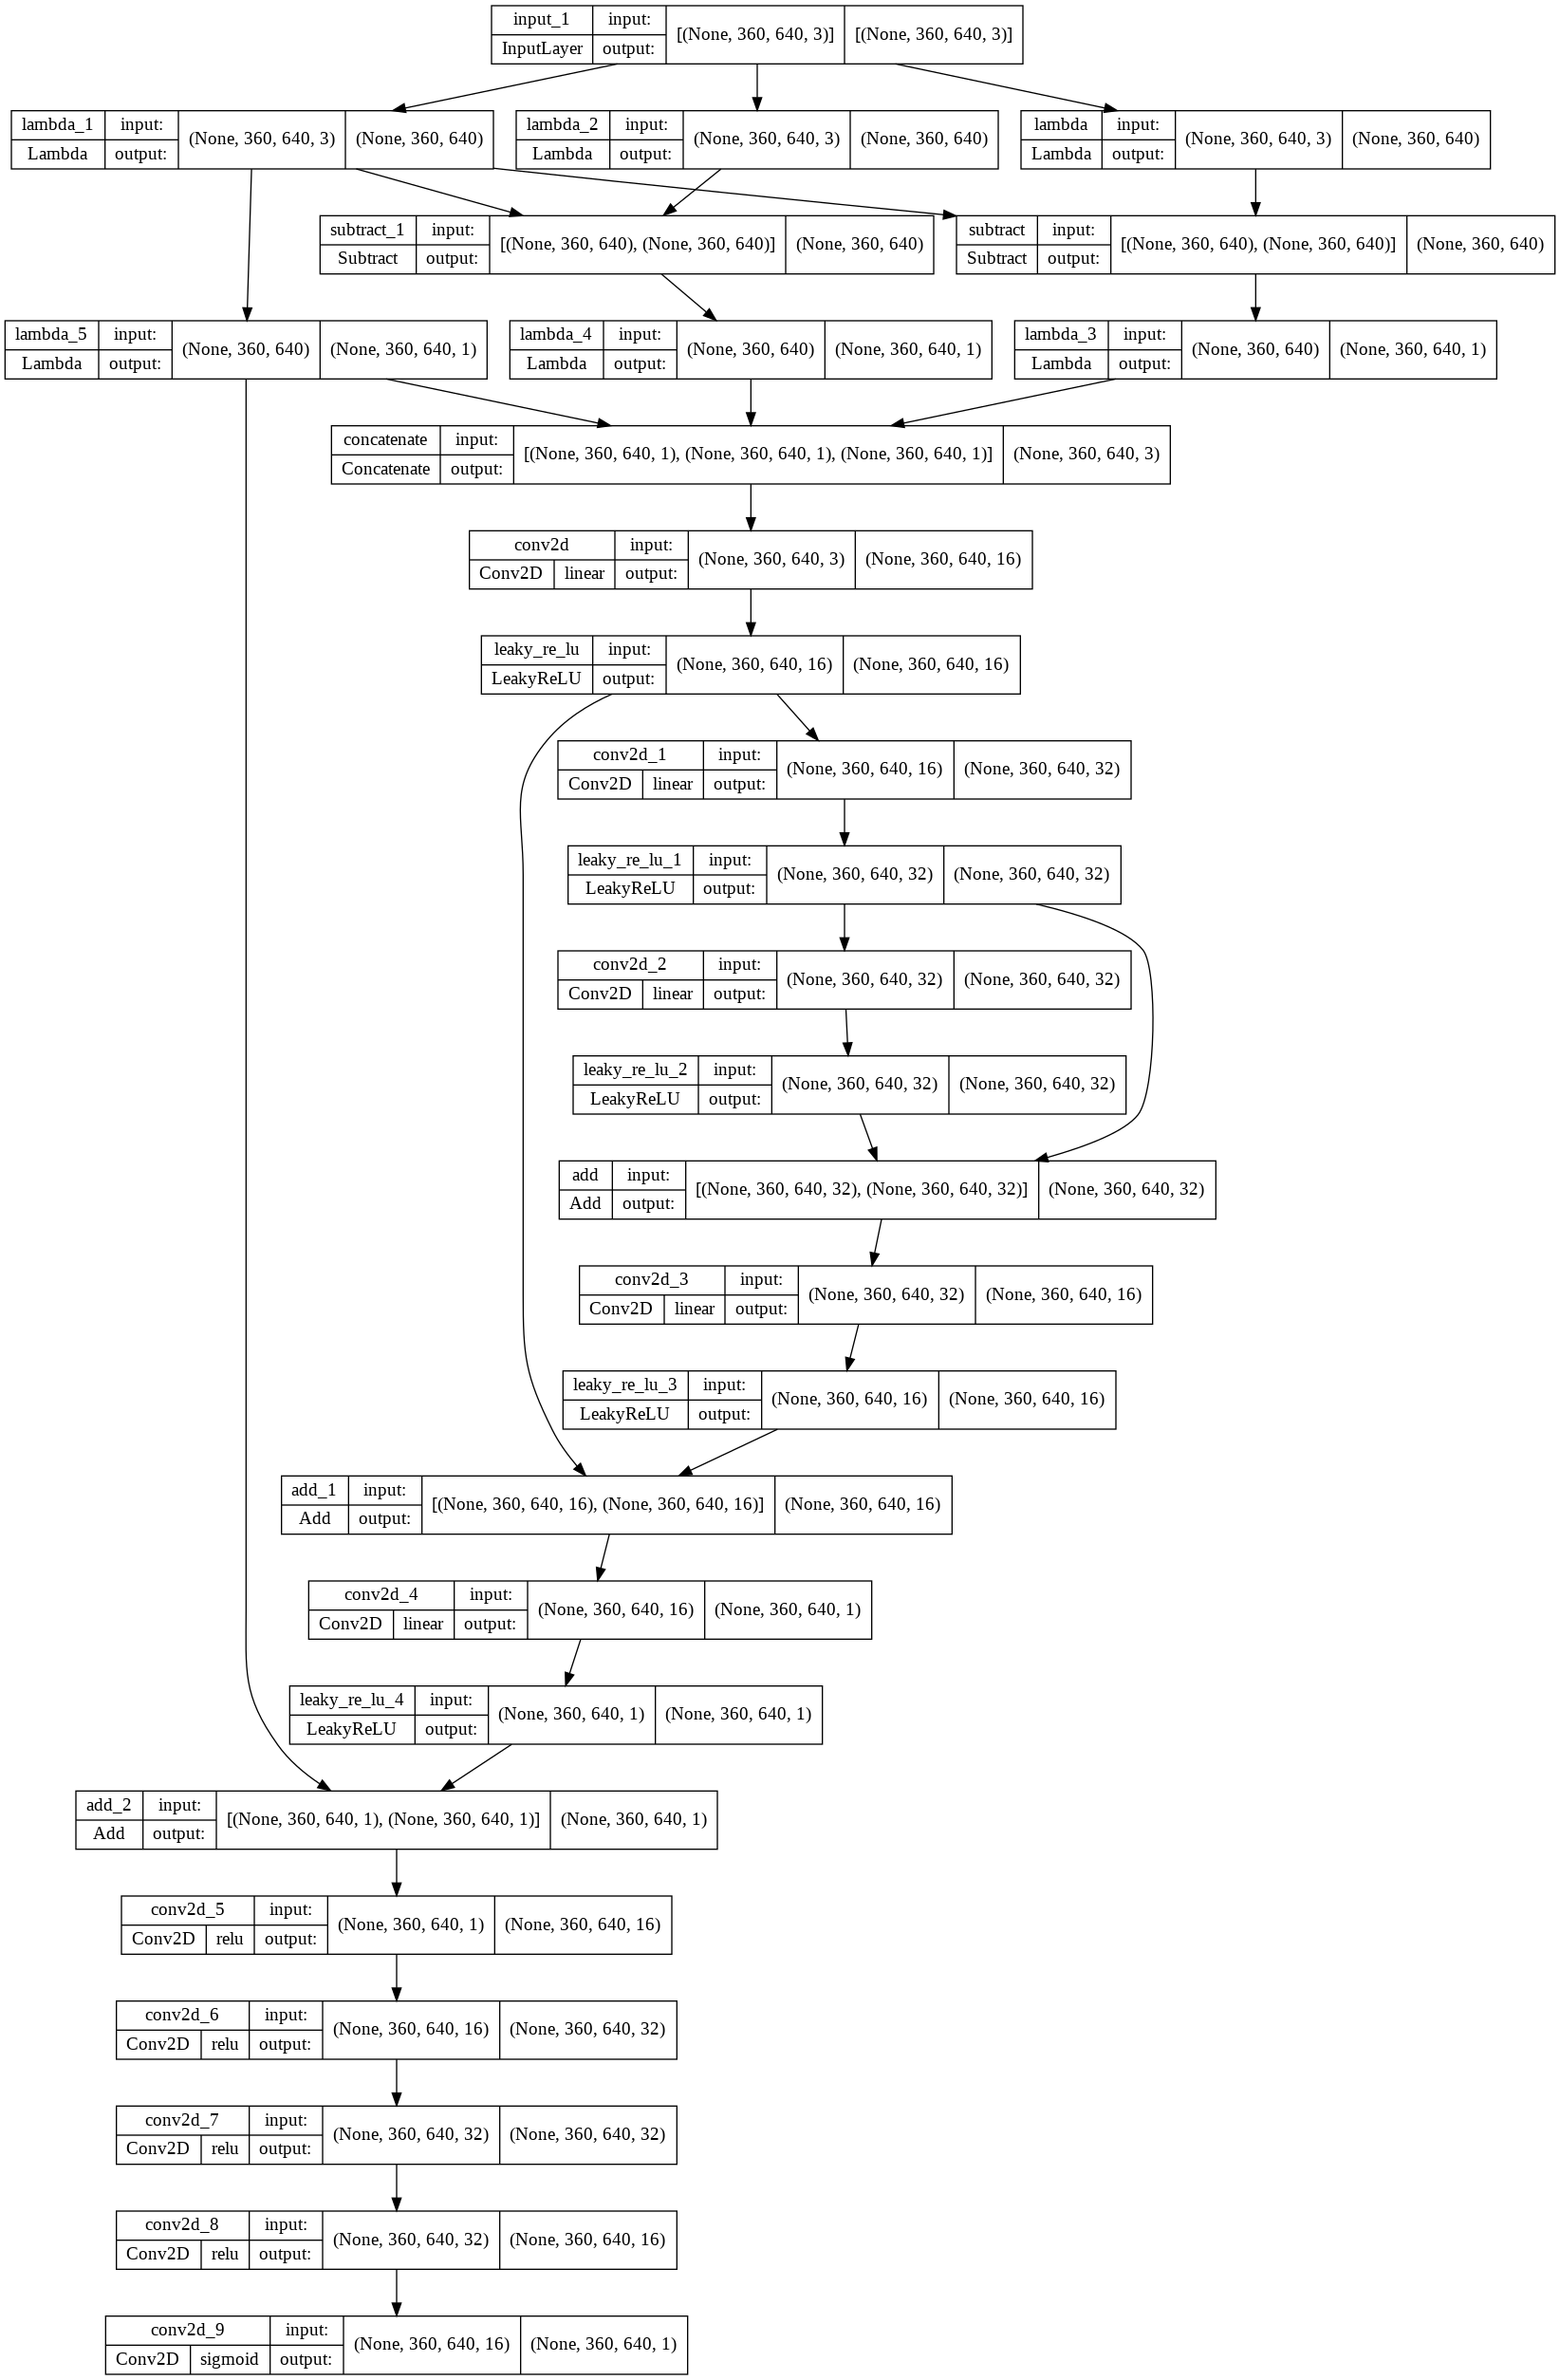

In [8]:
tf.keras.utils.plot_model(deblur_model_test, show_shapes = True, show_layer_activations=True)

In [9]:
loss_list = list()
total_losses = list()
total_losses.append(float('inf'))
num_epochs = 50
batch_size = 8

In [10]:
# len(train_imgs)
# train_batch

In [86]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=2),
    # tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience = 5)
]

for i in range(num_epochs):
  rand_idx = np.random.choice(range(1, len(train_imgs)-1), batch_size)
  train_batch = np.zeros((batch_size, 360, 640, 3))
  for j, ind in enumerate(list(rand_idx)):
    train_batch[j,:,:,0] = cv2.cvtColor(load_img(train_imgs[ind-1]), cv2.COLOR_RGB2YCrCb)[:, :, 0]
    train_batch[j,:,:,1] = cv2.cvtColor(load_img(train_imgs[ind]), cv2.COLOR_RGB2YCrCb)[:, :, 0]
    train_batch[j,:,:,2] = cv2.cvtColor(load_img(train_imgs[ind+1]), cv2.COLOR_RGB2YCrCb)[:, :, 0]
  # train_batch = np.array([[cv2.cvtColor(load_img(train_imgs[ind-1]), cv2.COLOR_RGB2YCrCb)[:, :, 0], cv2.cvtColor(load_img(train_imgs[ind]), cv2.COLOR_RGB2YCrCb)[:, :, 0], cv2.cvtColor(load_img(train_imgs[ind+1]), cv2.COLOR_RGB2YCrCb)[:,:,0]] for ind in rand_idx])
  test_batch = np.array([cv2.cvtColor(load_img(test_imgs[i]), cv2.COLOR_RGB2YCrCb)[:, :, 0] for i in rand_idx])
  train_batch = np.squeeze(train_batch)/255.0
  test_batch = np.expand_dims(test_batch, axis = -1)/255.0
  # train_batch = train_batch.reshape((batch_size, 360, 640, 3))
  # print(f'test_shape: {test_batch.shape}')
  # print(f'train_shape: {train_batch.shape}')
  print(f'Episodic Epoch {i+1}: ')
  hist = deblur_model_test.fit(train_batch, 
                               test_batch, 
                               epochs=10,
                               callbacks=my_callbacks, 
                               verbose = 0
                               )
  print(f'loss: {np.mean(hist.history["loss"])}')
  
  loss_list.append(hist.history['loss'])
  if(len(total_losses)>0 and total_losses[-1]>np.mean(hist.history["loss"])):
    print(f'Episodic loss improved from {total_losses[-1]} to {np.mean(hist.history["loss"])}. Saving best weights')
    if(os.path.exists('/content/drive/MyDrive/DLProject/')!=True):
      os.mkdir('/content/drive/MyDrive/DLProject/')
    tf.keras.models.save_model(deblur_model_test, '/content/drive/MyDrive/DLProject/model_2', save_format='tf')  
    total_losses.append(np.mean(hist.history["loss"]))

Episodic Epoch 1: 


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


loss: 0.002636148501187563
Episodic Epoch 2: 
loss: 0.002470863051712513
Episodic Epoch 3: 
loss: 0.0035981245571747424
Episodic Epoch 4: 
loss: 0.0019657830242067577
Episodic Epoch 5: 
loss: 0.0030702151590958236
Episodic Epoch 6: 
loss: 0.0029109881492331625
Episodic Epoch 7: 
loss: 0.0031734441174194215
Episodic Epoch 8: 
loss: 0.0026339423144236206
Episodic Epoch 9: 
loss: 0.0031946688890457154
Episodic Epoch 10: 
loss: 0.0016962329624220728
Episodic loss improved from 0.0017447465448640286 to 0.0016962329624220728. Saving best weights
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DLProject/model_2/assets
Episodic Epoch 11: 


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


loss: 0.0038320647552609445
Episodic Epoch 12: 
loss: 0.0020432132529094814
Episodic Epoch 13: 
loss: 0.0019435437628999353
Episodic Epoch 14: 
loss: 0.002207393408752978
Episodic Epoch 15: 
loss: 0.003166406904347241
Episodic Epoch 16: 
loss: 0.0018835201393812896
Episodic Epoch 17: 
loss: 0.004268211033195257
Episodic Epoch 18: 
loss: 0.00322625027038157
Episodic Epoch 19: 
loss: 0.004766339622437954
Episodic Epoch 20: 
loss: 0.003003050549887121
Episodic Epoch 21: 
loss: 0.0026654932182282208
Episodic Epoch 22: 
loss: 0.002715445775538683
Episodic Epoch 23: 
loss: 0.002546303323470056
Episodic Epoch 24: 
loss: 0.0029626607662066816
Episodic Epoch 25: 
loss: 0.0022994127590209245
Episodic Epoch 26: 
loss: 0.0033009637147188185
Episodic Epoch 27: 
loss: 0.003855731035582721
Episodic Epoch 28: 
loss: 0.0025355377234518527
Episodic Epoch 29: 
loss: 0.0030916441464796662
Episodic Epoch 30: 
loss: 0.002288851118646562
Episodic Epoch 31: 
loss: 0.0018634913838468492
Episodic Epoch 32: 
los

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


loss: 0.0029837529873475432
Episodic Epoch 49: 
loss: 0.003234147280454636
Episodic Epoch 50: 
loss: 0.0023700074991211293


In [87]:
# cv2_imshow(train_batch[1, :, :, 1]*255)

In [92]:
loss_list

[0.0709257647395134,
 0.0848941057920456,
 0.11004634946584702,
 0.07730734348297119,
 0.05620528385043144,
 0.04683954268693924,
 0.03632614016532898,
 0.03127932548522949,
 0.026596320793032646,
 0.026919934898614883,
 0.026960285380482674,
 0.023145833984017372,
 0.021752508357167244,
 0.017321575433015823,
 0.016842996701598167,
 0.03149988502264023,
 0.01170391496270895,
 0.012529094703495502,
 0.020097805187106133,
 0.011654200963675976,
 0.010896473191678524,
 0.009447972290217876,
 0.010894078761339188,
 0.010323865339159966,
 0.005894115194678307,
 0.009028112515807152,
 0.006621218286454678,
 0.0077516925521194935,
 0.007217530161142349,
 0.004631372634321451,
 0.009420404210686684,
 0.008008915930986404,
 0.008265858516097069,
 0.006891478318721056,
 0.006830562837421894,
 0.007392505183815956,
 0.006870322860777378,
 0.007000344805419445,
 0.00594042195007205,
 0.0063165235333144665,
 0.005852273665368557,
 0.0058223227970302105,
 0.006001684814691544,
 0.005758090410381555

In [126]:
len(loss_list)

550

In [127]:
l_end = loss_list[-50:]
# loss_list = [l+list(losses) for losses in loss_list]
# loss_list = list(loss_list)

In [128]:
l_end = np.array(l_end).reshape((-1))

In [131]:
f_loss = loss_list[:499]+list(l_end)

Text(0.5, 1.0, 'Training loss')

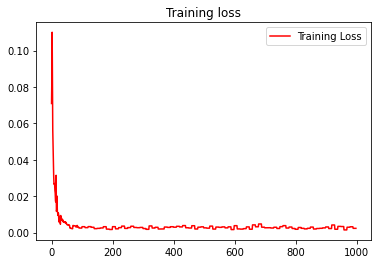

In [137]:
epochs=range(len(f_loss))
plt.plot(epochs, f_loss, 'r', label = "Training Loss")
# plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend()

plt.title('Training loss')

In [138]:
# if(os.path.exists('/content/drive/MyDrive/DLProject/')!=True):
#   os.mkdir('/content/drive/MyDrive/DLProject/')
# tf.keras.models.save_model(deblur_model_test, '/content/drive/MyDrive/DLProject/model_2', save_format='tf')

In [139]:
deblur_model_test = tf.keras.models.load_model('/content/drive/MyDrive/DLProject/model_2')

# Inference

In [167]:
ind = np.random.choice(range(1, len(train_imgs)-1), 1).item()
train_batch = np.zeros((1, 360, 640, 3))
train_batch[0,:,:,0] = cv2.cvtColor(load_img(train_imgs[ind-1]), cv2.COLOR_RGB2YCrCb)[:, :, 0]
train_batch[0,:,:,1] = cv2.cvtColor(load_img(train_imgs[ind]), cv2.COLOR_RGB2YCrCb)[:, :, 0]
train_batch[0,:,:,2] = cv2.cvtColor(load_img(train_imgs[ind+1]), cv2.COLOR_RGB2YCrCb)[:, :, 0]
# train_batch = np.array([cv2.cvtColor(load_img(train_imgs[ind-1]), cv2.COLOR_RGB2YCrCb)[:, :, 0], cv2.cvtColor(load_img(train_imgs[ind]), cv2.COLOR_RGB2YCrCb)[:, :, 0], cv2.cvtColor(load_img(train_imgs[ind+1]), cv2.COLOR_RGB2YCrCb)[:,:,0]])
test_batch = np.array(cv2.cvtColor(load_img(test_imgs[ind]), cv2.COLOR_RGB2YCrCb)[:, :, 0])
train_batch = train_batch/255.0
train_batch.shape

(1, 360, 640, 3)

In [168]:
t_frame = np.squeeze(train_batch[0, :, :, 1])
# t_frame = t_frame*255

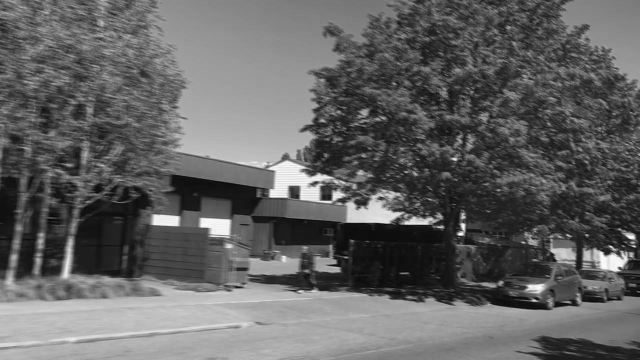

In [169]:
cv2_imshow(t_frame*255)

In [170]:
recon = deblur_model_test.predict(train_batch)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [171]:
img = np.squeeze(recon)
# img = np.array(img*255, dtype = np.uint8)
img.shape

(360, 640)

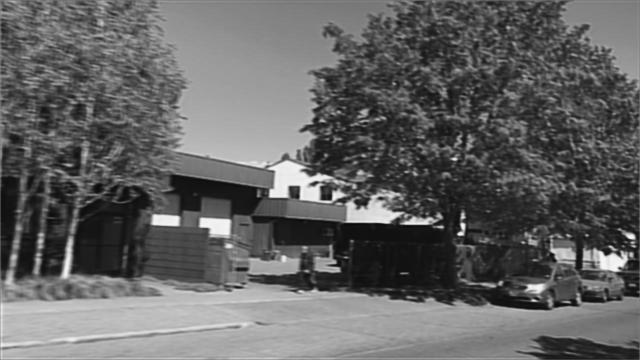

In [172]:
cv2_imshow(np.abs(img*255))

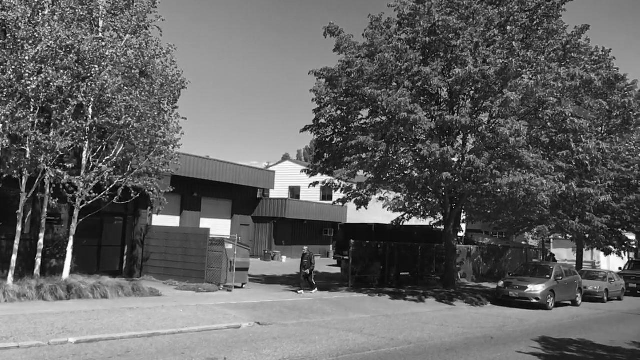

In [173]:
cv2_imshow(test_batch)

In [174]:
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = np.sqrt(np.mean(diff ** 2))

    return 20 * np.log10(255. / rmse)

In [175]:
psnr(test_batch,img*255), psnr(test_batch, t_frame*255)

(22.763652072490718, 23.04956250662244)

In [176]:
sharpness_prior = 1-(np.abs(img-t_frame))

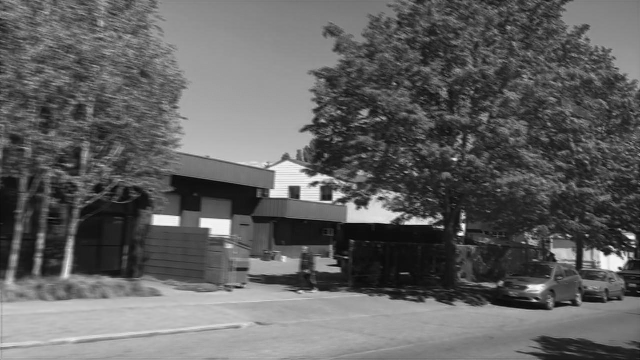

In [177]:
cv2_imshow(sharpness_prior*t_frame*255)

In [178]:
psnr(test_batch,sharpness_prior*t_frame*255), psnr(test_batch, t_frame*255)

(22.946973204847186, 23.04956250662244)

In [164]:
# np.max(recon)